##  1) İş Anlama (Business Understanding)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

##  2) Veri Anlama (Data Understanding)

In [4]:
df_raw=pd.read_csv('weatherAUS.csv')
df_raw.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
df_raw.shape

(145460, 23)

In [7]:
df = df_raw.replace("NA", np.nan)

In [9]:

print("Sütun tipleri:\n", df.dtypes.head())

Sütun tipleri:
 Date         object
Location     object
MinTemp     float64
MaxTemp     float64
Rainfall    float64
dtype: object


In [10]:
drop_cols = [
    "Date", "RainToday", "RainTomorrow",
    "WindDir9am", "WindDir3pm", "WindGustDir"
]
for c in drop_cols:
    if c in df.columns: df.drop(columns=c, inplace=True)

## 3) Veri Hazırlama (Data Preparation)

In [11]:
#Şehir adı
assert "Location" in df.columns, "Location sütunu bulunamadı."

In [12]:
# Sayısal sütunlar (Location dışındakileri deneriz)
num_cols = [c for c in df.columns if c != "Location"]

In [13]:
# Güvenli sayıya çevir: çevrilemeyenleri NaN yap
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [14]:
# Eksikleri ortalama ile doldur (satır seviyesinde değil, sütun ortalaması)
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [15]:
# Şehir bazında ortalama (KNIME GroupBy ile aynı)
df_city = df.groupby("Location", as_index=False)[num_cols].mean()

In [16]:
# Ölçekleme (Z-score)
scaler = StandardScaler()
X = scaler.fit_transform(df_city[num_cols])
X_df = pd.DataFrame(X, columns=[f"Mean({c})" for c in num_cols], index=df_city["Location"])
X_df.reset_index(inplace=True)
X_df.rename(columns={"Location":"Location"}, inplace=True)

print("Şehir-bazlı ölçeklenmiş veri şekli:", X_df.shape)
print(X_df.head())

Şehir-bazlı ölçeklenmiş veri şekli: (49, 17)
        Location  Mean(MinTemp)  Mean(MaxTemp)  Mean(Rainfall)  \
0       Adelaide       0.082961      -0.124567       -0.671904   
1         Albany       0.174078      -0.822082       -0.065804   
2         Albury      -0.700282      -0.189044       -0.377684   
3   AliceSprings       0.227987       1.471913       -1.306924   
4  BadgerysCreek      -0.286837       0.158277       -0.126160   

   Mean(Evaporation)  Mean(Sunshine)  Mean(WindGustSpeed)  Mean(WindSpeed9am)  \
0           0.128657        0.115007            -0.876202           -1.059330   
1          -1.058943       -1.211548            -0.007624           -0.400350   
2          -0.019048       -0.001053            -1.737125           -1.501142   
3           3.010306        2.500323             0.113164            0.160290   
4          -0.019048       -0.001053            -1.560981           -1.521464   

   Mean(WindSpeed3pm)  Mean(Humidity9am)  Mean(Humidity3pm)  \
0       

## 4) Modelleme (Modeling) – K-Means

In [17]:
def fit_kmeans_return_labels(X, k, random_state=123):
    model = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    return model, labels, sil

In [18]:
# k optimizasyonu (isteğe bağlı)
k_grid = [3,4,5]
best = {"k":None, "score":-1, "model":None, "labels":None}
for k in k_grid:
    m, lab, s = fit_kmeans_return_labels(X_df.drop(columns=["Location"]).values, k)
    print(f"k={k} -> silhouette: {s:.3f}")
    if s > best["score"]:
        best.update({"k":k, "score":s, "model":m, "labels":lab})

print(f"Seçilen k={best['k']}, silhouette={best['score']:.3f}")
kmeans = best["model"]
labels = best["labels"]

k=3 -> silhouette: 0.267
k=4 -> silhouette: 0.243
k=5 -> silhouette: 0.248
Seçilen k=3, silhouette=0.267


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
# Sonuçları tabloya ekle
result = X_df.copy()
result["Cluster"] = labels

In [20]:
# Küme merkezleri (ölçeklenmiş uzayda)
centers_scaled = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=[c for c in result.columns if c.startswith("Mean(")]
)
centers_scaled["Cluster"] = range(kmeans.n_clusters)
centers_scaled = centers_scaled[["Cluster"] + [c for c in centers_scaled.columns if c!="Cluster"]]

print("\nKüme merkezleri (Z-score uzayı):\n", centers_scaled.round(3))


Küme merkezleri (Z-score uzayı):
    Cluster  Mean(MinTemp)  Mean(MaxTemp)  Mean(Rainfall)  Mean(Evaporation)  \
0        0         -0.054          0.440          -0.558              0.490   
1        1          2.326          2.046           1.824              1.116   
2        2         -0.319         -0.636           0.127             -0.530   

   Mean(Sunshine)  Mean(WindGustSpeed)  Mean(WindSpeed9am)  \
0           0.729               -0.635              -0.459   
1           0.605               -0.248               0.120   
2          -0.626                0.502               0.317   

   Mean(WindSpeed3pm)  Mean(Humidity9am)  Mean(Humidity3pm)  \
0              -0.759             -0.605             -0.860   
1               0.587             -0.232              0.317   
2               0.464              0.478              0.579   

   Mean(Pressure9am)  Mean(Pressure3pm)  Mean(Cloud9am)  Mean(Cloud3pm)  \
0              0.311              0.062          -0.615          -0.653

##  5) Değerlendirme (Evaluation)

In [21]:
print(f"\nNihai silhouette skoru (k={best['k']}): {best['score']:.3f}")



Nihai silhouette skoru (k=3): 0.267


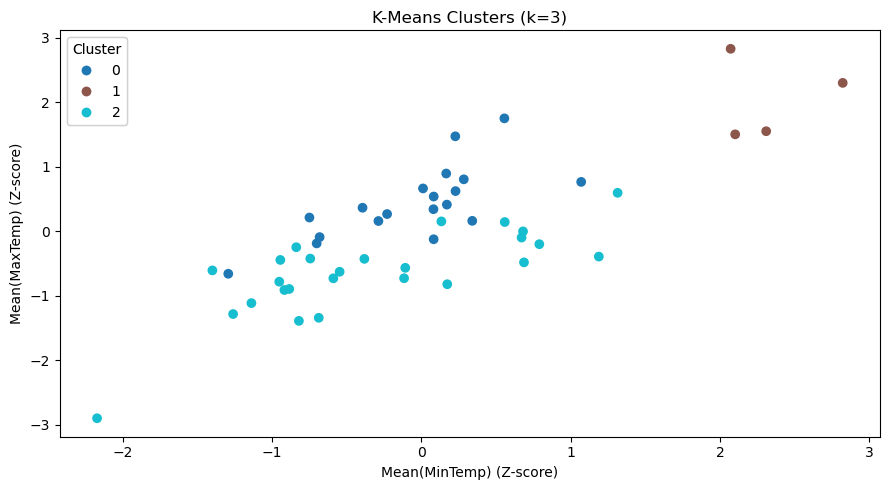

In [ ]:
# Görselleştirme
fig, ax = plt.subplots(figsize=(9,5))
x = result["Mean(MinTemp)"]
y = result["Mean(MaxTemp)"]
scatter = ax.scatter(x, y, c=result["Cluster"], cmap="tab10")
ax.set_xlabel("Mean(MinTemp) (Z-score)")
ax.set_ylabel("Mean(MaxTemp) (Z-score)")
ax.set_title(f"K-Means Clusters (k={best['k']})")
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
plt.tight_layout()
plt.show()